# 3'READS+ Pipeline (Part 2)
**This notebook is the Part 2 of the 3'READS+ pipeline, which will do the following:**

1. Register settings for this analysis. One experiment can be analysed with different settings (parameters). The results for each setting will be saved in different folders under the *result_dir* directory. 
2. Extend annotated 3'UTR regions to allow identification of new pA sites in previously poorly annotated 3'UTRs. 
3. Assign pA clusters identified in Part 1 to genomic features such as extended 3'UTRs, introns, CDSs, and 5'UTRs.
4. Resolve pA sites mapped to multiple genes.
5. Map intergenic and intronic pA sites to Non-Coding RNAs (ncRNAs).
6. Map remaining intergenic pA sites to Upstream Antisense RNAs (uaRNAs).
7. Plot the fractions of pA sites and PASS reads mapped to mitochondria.
8. Resolve pA sites mapped to multiple genomic features of the same gene.
9. Plot distribution of pA sites and PASS reads in different genomic features of each sample.
10. Plot nucleotide profile near pA sites
11. Calculate optimal Transcript Starting Sites (TSSs).
12. Calculate CDS, intronic, 5'UTR, 3'UTR, and ncRNA features, such as size, GC content, and uORF.
13. Identify subtypes of pA sites.
14. Identify poly(A) signal (PAS).
15. Calculate gene expression-related features, such as pA site level RPM, gene level RPM, and pA site usage.
16. Filter out lowly expressed pAs and check corrrelation between samples
17. Add gene symbols and Entrez gene ids to the data frame.


**Required softwares**

 * [dzlib.R](https://github.com/DinghaiZ/3-prime-READS-plus/blob/master/modules/dzlib.R) in the [modules](https://github.com/DinghaiZ/3-prime-READS-plus/tree/master/modules) folder 
 * Jupyter Lab or Jupyter Notebook for runing this notebook
 * R packages: foreach, doParallel, ShortRead, Biostrings, dplyr, tidyr, grid, ggplot2, plotly, etc
 * Linux environment
 
**Hardware requirements**
 * Muticore CPU for parallel computing

## 1. Set configurations specific to this project, experiment, and analysis
These parameters need to be specified for different projects and experiments. One experiment can be analysed with different settings. 

In [2]:
# SHARED_DATA_DIR is a directory containing frequently used data, such as annotation databases.
SHARED_DATA_DIR = '/home/dinghai/projects/fud'

# Each data set can be analyzed with different parameter settings
SETTING = 'NT_AS_RC'

In [3]:
if(SETTING == 'NT_AS_RC'){
  # Which genome was used for mapping?  
  GENOME = 'mm9' # Genome name, currently either mm9 or hg19
  # Define which sample conditions to focus on
  # As mentioned in Part-1 of the pipeline, sample names should be in the format of 
  # "Treatment_Fraction_Batch", such as in "NT_C_1" and "NT_N_1".
  treatments = c("NT", "AS", "RC") # Order matters. Earlier ones will be reference
  fractions = c("4sU", "Ft") # Order matters. Earlier ones will be reference 
  comparisons = c("Ft_4sU") # Comparisons to make: N vs C
    
  # Use unique PASS reads for analysis?
  uPASS = F 
  if(uPASS){
    cluster_file = paste0('../results/clusters.using.unique.reads.csv')
    cluster_min_count = 2
  }else{
    cluster_file = paste0('../results/clusters.using.all.reads.csv')
    cluster_min_count = 5
  }
    
  # Settings for filtering low expression pAs 
  lowest_usage = 0 # Percentage 
  lowest_rpm = 0 # 
  lowest_count = 5
  filter_strength = 1 # Fraction of samples satisfying the filters
    
  # When a pA site map to mutlple genomic features of the same gene due to alternative splicing,
  # should we simplify the "region" annotation? 
  simplify_region_annotation = T
  
  # Settings for identifying aUTRs
  neighbor = F # Calculate aUTRs for each neighboring isoforms?
  toptwo = T # Pick top two isoforms for each gene?
  
  # Number of CPUs for parallel computing 
  MAX_WORKERS = 8  
}

In [4]:
result_dir = paste0("../results/", SETTING)
system(paste0("mkdir ", result_dir))
cat("Analysis results will be saved in the following directory:", result_dir) 

Analysis results will be saved in the following directory: ../results/NT_AS_RC

Load packages:

In [5]:
require(tidyr)
require(magrittr)
require(dplyr)
require(ggplot2)
require(plotly)
require(gplots)
require(GenomicFeatures)
require(GenomicRanges)
require(Biostrings)
require(docstring)
require(foreach)
require(doParallel)
registerDoParallel(MAX_WORKERS)
theme_set(theme_bw(base_size = 15) + theme(plot.title = element_text(hjust = 0.5)))
library(repr)

# Depending on the genome, load the right packages:
if(GENOME == "mm9"){
  require("org.Mm.eg.db")
  org.db = org.Mm.eg.db
  txdb_path = file.path(SHARED_DATA_DIR, "mm9.refGene.txdb.sqlite")
  BSspec = "Mmusculus"
}else if(GENOME == "hg19"){
  require("org.Hs.eg.db")
  org.db = org.Hs.eg.db
  txdb_path = file.path(SHARED_DATA_DIR, "hg19.refGene.txdb.sqlite")
  BSspec = "Hsapiens"
}
    
BSgeno = paste0("BSgenome.", BSspec, ".UCSC.", GENOME)
require(BSgeno, character.only = T) 

Loading required package: tidyr
Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: plotly

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: GenomicFeatures
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following object

If the txDb has not been downloaded yet, download it and save it to the shared data directory:

In [6]:
tryCatch(
  {txdb = loadDb(txdb_path)},
  error = function(e){
    txdb = makeTxDbFromUCSC(genome = GENOME, tablename = 'refGene')
    saveDb(txdb, file.path(SHARED_DATA_DIRD, paste0(GENOME, ".refGene.txdb.sqlite")))
  }
)

Load custom functions defined in *dzlib.R*:

In [8]:
source("/home/dinghai/dev/3-prime-READS-plus/modules/dzlib.R")


Attaching package: ‘MASS’

The following object is masked from ‘package:AnnotationDbi’:

    select

The following object is masked from ‘package:plotly’:

    select

The following object is masked from ‘package:dplyr’:

    select



## 2. Extend annotated 3'UTR regions to allow identification of new pA sites in poorly annotated 3'UTRs. 

First, define a helper function that will be reused several times later. 

In [9]:
rename_grl = function(grl, old_key = "ACCNUM", new_key = "SYMBOL"){
    #' A function to rename GRanges in a GRangeList.
    
    # Convert a GRangeList to a GRanges for faster calculation
    gr = unlist(grl)

    # Convert the accession numbers of the genes into gene symbols
    names(gr) = mapIds(org.db, keys = names(gr), keytype = old_key, column = new_key)
    
    # Rebuild GRanges by gene symbol 
    grl = split(gr, names(gr))   

    # Collapse features
    grl = reduce(grl)
    
    # Remove GRanges that are on two strands
    grl[sapply(grl, function(x) length(strand(x)@values) == 1)]
}

To extend 3'UTRs, I first get 4 kb regions downstream of annotated 3'UTRs. If the downstream regions overlap with downstream genes, I'll shrink the downstream regions to avoid overlaps. On the other hand, if the beginnings of the downstream regions are located within any genes (e.g. intronic 3'UTRs), I will undo the extension by setting the start and end of the extension to be identical. Downstream regions are processed separately for 3'UTRs on the plus and minus strands. Finally, the 3'UTRs and downstream regions are combined to get extended 3'UTRs. **Please note that the extended 3'UTRs are just candidate 3'UTR regions. The exact 3'UTR boundaries will be determined by pA sites that can be mapped to them.**

In [10]:
# Get 3'UTR annotation from Refseq
threeUTRs = threeUTRsByTranscript(txdb, use.names=T)

# Rename the 3'URs with gene symbols
threeUTRs = rename_grl(threeUTRs, old_key = "ACCNUM", new_key = "SYMBOL")

# Convert to GRanges for later use
utr3 = unlist(threeUTRs)

# Get 4 kb downstream regions. 3'UTR regions not included
# Out of boundary regions need to be trimmed
ds = trim(flank(utr3, 4000, start=F))

# Get GRanges for genes
genes = genes(txdb, filter=NULL, single.strand.genes.only=T)
 
# Find extensions that overlap with genes on positive strands:
olp = findOverlaps(ds[strand(ds) == "+"], genes[strand(genes) == "+"])

# Which 3'UTRs have been extended too far?
extended_into_genes = start(ds[strand(ds) == "+"][queryHits(olp)]) < 
                      start(genes[strand(genes) == "+"][subjectHits(olp)])

# Reset the extended region so that the extended region no longer overlap with genes
end(ds[strand(ds) == "+"][queryHits(olp)][extended_into_genes]) =
    start(genes[strand(genes) == "+"][subjectHits(olp)][extended_into_genes]) - 1 

# If the bebinning of 3'UTR downstream region is located within any genes, don't extend either.
width(ds[strand(ds) == "+"][queryHits(olp)][!extended_into_genes]) = 1 

# Find extensions that overlap with genes on negative strands:
olp = findOverlaps(ds[strand(ds) == "-"], genes[strand(genes) == "-"])

# Which 3'UTRs have been extended too far?
extended_into_genes = end(ds[strand(ds) == "-"][queryHits(olp)]) > 
                      end(genes[strand(genes) == "-"][subjectHits(olp)])

# Reset the extended region so that the extended region no longer overlap with genes
start(ds[strand(ds) == "-"][queryHits(olp)][extended_into_genes]) = 
    end(genes[strand(genes) == "-"][subjectHits(olp)][extended_into_genes]) + 1 

# If the bebinning of 3'UTR downstream region is located within any genes, don't extend either.
end(ds[strand(ds) == "-"][queryHits(olp)][!extended_into_genes]) = 
    start(ds[strand(ds) == "-"][queryHits(olp)][!extended_into_genes]) 

# Combind previous 3'UTR definition with the downstream region to define extended 3'UTRs
utr3 = resize(utr3, width = width(utr3) + width(ds)-1, fix="start")

# Rebuild 3'UTRs named by gene symbol 
threeUTRs = split(utr3, names(utr3))

Warning message in .set_group_names(ans, use.names, txdb, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 4 out-of-bound ranges located on sequences
  chrUn_random, chr12, chr13, and chr3. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”

The above code will generate some warning messages. The second warning message was produced by the flank() function, but the trim() function will take care of the issue. Take a look at how the size of extensions distribute:

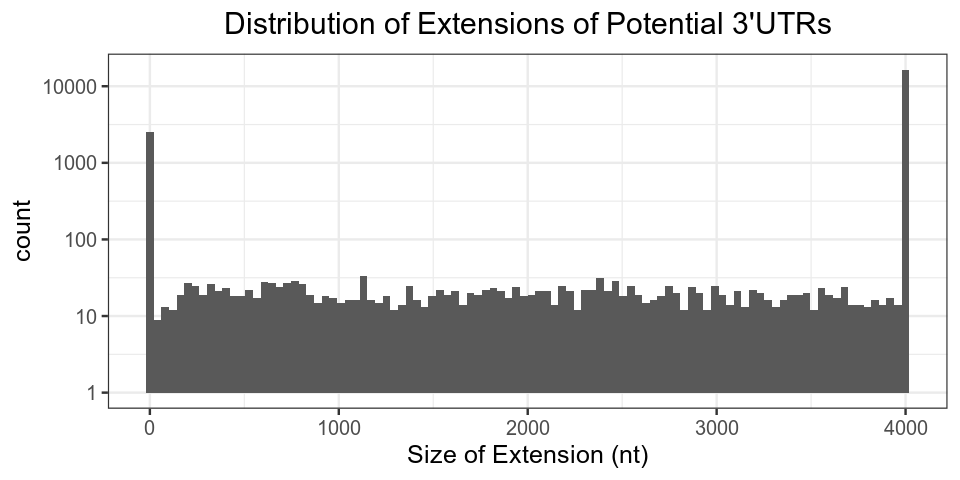

In [91]:
df = data.frame(extended = width(ds)) 

options(repr.plot.width=8, repr.plot.height=4)

ggplot(df, aes(extended)) +
  geom_histogram(bins=100) +
  scale_y_log10() +
  xlab("Size of Extension (nt)") +
  ggtitle("Distribution of Extensions of Potential 3'UTRs")

## 3.1. Read the pA cluster file created in Part-1 of the pipeline and create a GRange:
Only read data for the samples defined in Step 1. 

In [12]:
# Calculate sample names and batch numbers
header = strsplit(readLines(cluster_file, n = 1), ",")[[1]]

sample_names = grep(paste0("(", paste0(treatments, collapse="|"), 
                           ")_(", paste0(fractions,collapse="|"), 
                           ")_\\d+"), 
                    header[-c(1:3)], value = T)

batches = unique(sub(".+_(\\d+.?)$", "\\1", sample_names)) 

cat(paste0("The following samples will be used for the analysis named '", SETTING, "':")) 
sample_names

The following samples will be used for the analysis named 'NT_AS_RC':

[1] "AS_4sU_1" "AS_4sU_2" "AS_Ft_1"  "AS_Ft_2"  "NT_4sU_1" "NT_4sU_2"
 [7] "NT_4sU_3" "NT_Ft_1"  "NT_Ft_2"  "NT_Ft_3"  "RC_4sU_2" "RC_Ft_2"

In [13]:
# Only read desirable columns of the cluster file
cluster = read.csv(cluster_file)[, c("chromosome","strand","position", sample_names)]

# Require at least cluster_min_count reads for more than 2 samples
cluster = subset(cluster, rowSums(cluster[,-c(1:3)] >= cluster_min_count) >= 2)

# Create a GRanges object
pA = GRanges(seqnames = cluster$chromosome, strand = cluster$strand,
             ranges = IRanges(start = cluster$position, end = cluster$position))

mcols(pA, use.names = T) = cluster[,-c(1:3)]

rm(cluster)

## 3.2. Map the pA sites to extended 3'UTRs

In [14]:
pA$gene_symbol = ""
pA$region = ""
olp = findOverlaps(pA, threeUTRs)
pA[queryHits(olp), ]$gene_symbol = names(threeUTRs[subjectHits(olp)])
pA[queryHits(olp), ]$region = "3UTR"

## 3.3. Map the pA sites to introns
Code for steps 3.3 ~ 3.5 can be refactored later, since the steps are similar.

In [15]:
# Get intron annotation
introns = intronsByTranscript(txdb, use.names=T)

# Use the previously defined helper function to rename introns
introns = rename_grl(introns, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which introns?
olp = findOverlaps(pA, introns)

# Some "intronic" pA sites have never been considered as 3'UTR pA sites 
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
pA[queryHits(olp), ][index1, ]$gene_symbol = names(introns[subjectHits(olp[index1,])])
pA[queryHits(olp), ][index1, ]$region = "intron"

# Some "intronic" pA sites have already been considered as 3'UTR pA sites 
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
pA[queryHits(olp), ][index2, ]$gene_symbol = paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, 
                                                    "|", 
                                                    names(introns[subjectHits(olp[index2,])]))
pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|intron")

Warning message in .set_group_names(ans, use.names, x, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


## 3.4. Map the pA sites to CDS
Code for steps 3.3 ~ 3.5 can be refactored later, since the steps are similar.

In [16]:
# Get CDS annotation
cds = cdsBy(txdb, by="tx", use.names=T)

# Use the previously defined helper function to rename CDS
cds = rename_grl(cds, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which cds?
olp = findOverlaps(pA, cds)

# Some "CDS" pAs have never been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
if(length(index1) > 0){
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(cds[subjectHits(olp[index1,])])
  pA[queryHits(olp), ][index1, ]$region = "CDS"
  }

# Some "CDS" have already been considered as other featuers
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
if(length(index2) > 0){
  pA[queryHits(olp), ][index2, ]$gene_symbol = 
    paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", 
           names(cds[subjectHits(olp[index2,])]))
  pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|CDS")
  }

Warning message in .set_group_names(grl, use.names, txdb, by):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


## 3.5. Map the pA sites to 5'UTRs
Code for steps 3.3 ~ 3.5 can be refactored later, since the steps are similar.

In [17]:
# Get 5'UTR annotation
fiveUTRs = fiveUTRsByTranscript(txdb, use.names=T) 

# Use the previously defined helper function to rename CDS
fiveUTRs = rename_grl(fiveUTRs, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which 5'UTRs?
olp = findOverlaps(pA, fiveUTRs)

# Some 5'UTR pA sites have never been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
if(length(index1) > 0){
  pA[queryHits(olp), ][index1, ]$region = "5UTR"
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(fiveUTRs[subjectHits(olp[index1,])])
  }

# Some 5'UTRs have already been considered as other featuers
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
if(length(index2) > 0){
  pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|5UTR")
  pA[queryHits(olp), ][index2, ]$gene_symbol = 
    paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", 
           names(fiveUTRs[subjectHits(olp[index2,])]))
  }

pA[pA$region == ""]$region = "intergenic"

Warning message in .set_group_names(ans, use.names, txdb, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


## 4. Resolve pA sites mapped to multiple genes.
Some pA sites are mapped to multiple genes. The conflict will be resolved based on the priority of 3UTR > intron > CDS.

In [18]:
# Resolve pAs mapped to multiple genes
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
                      
# If the first region annotation is 3UTR, then only keep the first gene_symbol 
if(length(index1) > 0){
  index2 = grepl("^3UTR", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "3UTR"
}
                      
# Next, if the first region annotation is intron, then only keep the first gene_symbol 
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if(length(index1) > 0){
  index2 = grepl("^intron", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "intron"
}

# Next, if the first region annotation is CDS, then only keep the first gene_symbol
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if(length(index1) > 0){
  index2 = grepl("^CDS", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "CDS"
}
                      
# Delete other pAs that can be mapped to >1 gene
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if (length(index1) > 0){
  pA = pA[-index1,]
}
                      
# Now simplify gene_symbol for all genes
pA$gene_symbol = sub("\\|.+$", "", pA$gene_symbol)
pA$gene_symbol[pA$gene_symbol == ""] = "Unknown"

## 5. Map intergenic and intronic pA sites to Non-Coding RNAs (ncRNAs)
Non-coding RNAs can be extracted from UCSC refGene table by requiring that *cdsStart* equals *cdsEnd*. 

In [72]:
# Get noncoding RNA annotation
con = src_mysql(dbname = GENOME, 
                user = "genome", 
                password = "", 
                host = "genome-mysql.cse.ucsc.edu")

ncTx = con %>%
  tbl("refGene") %>%
  filter(cdsStart==cdsEnd) %>%
  distinct() %>%
  collect()

# Convert to GRanges
ncTx = split(as.data.frame(ncTx), ncTx$name)

# A helper function to process CDS of transcripts in multiple exons
process_multi_exons = function(df){
  if(length(df$name) == 1){
    starts = as.numeric(strsplit(df$exonStarts, ",")[[1]])
    ends = as.numeric(strsplit(df$exonEnds, ",")[[1]])
    gr = GRanges(seqnames = df$chrom, strand = df$strand, 
                 ranges = IRanges(start=starts, end=ends))
    gr$gene_symbol = df$name
    gr
  }
}
ncTx = lapply(ncTx, process_multi_exons)
ncTx = GRangesList(ncTx[sapply(ncTx, class) == "GRanges"])

# Map pAs in intergernic or intronic region to ncRNAs
olp = findOverlaps(pA[grepl("intergenic|^intron", pA$region)], ncTx) 
                   
# Discard pAs mapped to multiple ncRNAs
olp = olp[!duplicated(queryHits(olp))]
                   
# Remove gene symbol of the host genes
pA[grepl("intergenic|^intron", pA$region)][queryHits(olp), ]$gene_symbol = 
                                              names(ncTx)[subjectHits(olp)]
                   
# Update region annotation
pA[grepl("intergenic|^intron", pA$region)][queryHits(olp), ]$region = "ncRNA"

Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 0 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 4 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 5 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 6 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 7 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 8 imported as numeric”

ERROR: Error in select(., name, chrom, strand, cdsStart, cdsEnd, exonStarts, : unused arguments (name, chrom, strand, cdsStart, cdsEnd, exonStarts, exonEnds, txStart, txEnd)


## 6. Map pA sites to Upstream Antisense RNAs (uaRNAs)
Transcription in sense direction produces mRNA, while upstream antisense transcription generates non-coding transcripts called uaRNA (upstream antisense RNA). I'll define the antisense 4000 kb region as candidate UA regions.

In [20]:
# Define UA (upstream antisense) regions
ua = promoters(txdb, upstream=4000, downstream=0) # returns 1 record per transcript 

# Reverse the strand to get antisense region
strand(ua) = Rle(as.factor(ifelse(strand(ua) == "+", "-", "+")))

# Convert the accession numbers of the genes into gene symbols
names(ua) = mapIds(org.db, keys = ua$tx_name, keytype =  "ACCNUM", column =  "SYMBOL")

ua = split(ua, names(ua))

'select()' returned 1:1 mapping between keys and columns


Map pA sites that have never been annotated to UA regions.

In [21]:
# Which clusters are mapped to which ua?
olp = findOverlaps(pA, ua)

# Which pAs have never been considered as other featuers?
index1 = which(pA[queryHits(olp), ]$gene_symbol == "Unknown") 

# Only update pAs that have never been considered as other featuers
if(length(index1)){
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(ua[subjectHits(olp[index1,])])
  pA[queryHits(olp), ][index1, ]$region = "UA"
}

## 7. Plot the fractions of PASS reads mapped to the mitochondria genome

In [64]:
# Count chrM reads
chrM_counts = colSums(data.frame(mcols(pA)[seqnames(pA)=="chrM",])[,sample_names])
total_counts = colSums(data.frame(mcols(pA))[,sample_names])

df = data.frame(chrM_counts, total_counts, sample_names) %>%
     mutate(chrM_fraction = chrM_counts/total_counts) %>%
     mutate(group = factor(sub("(.+)_\\d.*$", "\\1", sample_names))) %>%
     arrange(sample_names)

p = ggplot(df, aes(x = sample_names, y = chrM_fraction, fill = group)) +
    geom_col() +
    scale_fill_hue() +
    coord_flip() +
    scale_x_discrete(limits = rev(df$sample_names)) +
    xlab("Sample Names") +
    ylab("Fraction of chrM PASS reads") +
    ggtitle("Fraction of PASS reads Mapped to Mitochondria in Each Sample")

png(file.path(result_dir, "chrM_PASS_reads_fraction.png"), 100*nrow(df), 500)
print(p)
dev.off()

png 
  2

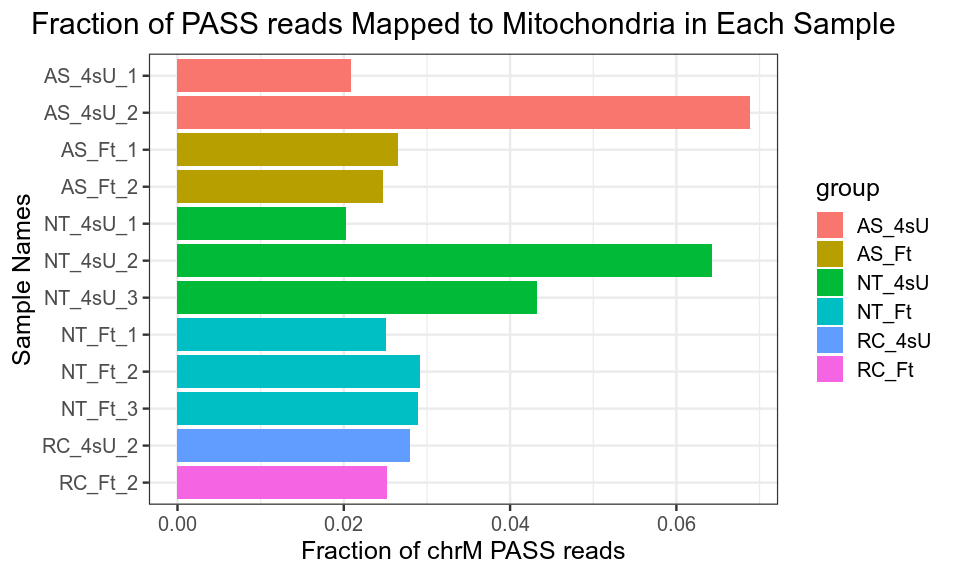

In [66]:
# Change plot size 
options(repr.plot.width=8, repr.plot.height=0.4*nrow(df))

p

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

png 
  2

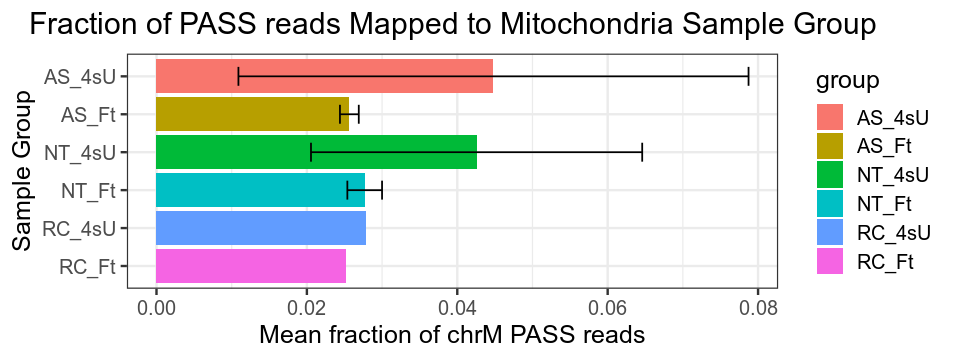

In [68]:
# Calculate mean and sd of chrM fractions
if(length(batches) > 1){
  sum_df = df %>%
    group_by(group) %>%
    summarise(chrM_mean_fraction = mean(chrM_fraction), chrM_fraction_sd = sd(chrM_fraction)) %>%
    ungroup()
  
  p = ggplot(sum_df, aes(x = group, y = chrM_mean_fraction, fill = group)) +
    geom_col() +
    geom_errorbar(aes(x = group, 
                      ymin = chrM_mean_fraction-chrM_fraction_sd, 
                      ymax = chrM_mean_fraction+chrM_fraction_sd), 
                  width = 0.5) + 
    coord_flip() +
    scale_x_discrete(limits = rev(sum_df$group)) +
    xlab("Sample Group") +
    ylab("Mean fraction of chrM PASS reads") +
    ggtitle("Fraction of PASS reads Mapped to Mitochondria Sample Group")
  
  options(repr.plot.width=8, repr.plot.height=0.5*length(unique(sum_df$group)))
  p
}

# Write to disk
if(length(batches) > 1){
  png(file.path(result_dir, "mean_chrM_reads_fraction.png"), 100*nrow(sum_df), 500)
  print(p)
  dev.off()
    }

Set the "region" of intergenic pAs mapped to the mitochondria genome to "chrM":

In [25]:
pA[pA$region == "intergenic" & seqnames(pA) == "chrM"]$region = "chrM"

## 8. Resolve pA sites mapped to multiple genomic features of the same gene
pA sites can be mapped to multiple genomic features of the same gene due to alternative splicing. By default, the region annotation is simplified unless specified otherwise.

In [26]:
# Fix pAs mapped to multiple features
if(!exists("simplify_region_annotation") || simplify_region_annotation){
  pA$region[grepl("\\|intron$", pA$region)] = "intron"
  pA$region[grepl("\\|CDS$", pA$region)] = "CDS"
  pA$region[grepl("\\|5UTR$", pA$region)] = "5UTR"
}

## 9. Plot summarised distribution of pA sites and reads in genomic features in each sample.
First, summarize pA sites and read numbers in each genomic features in each sample. pA sites with less than *min_count_* in the sample are omitted. The results are saved in an Excel file.

In [80]:
require(scales)
require(openxlsx)

min_count_ = 5 # Read count filter

df = mcols(pA)[, c("region", sample_names)]

# Collapse pAs mapped to multiple features
df$region[grepl("\\|intron$", df$region)] = "intron"
df$region[grepl("\\|CDS$", df$region)] = "CDS"
df$region[grepl("\\|5UTR$", df$region)] = "5UTR"

# Change region names so that they can be used as column names
df$region[df$region == "3UTR"] = "UTR3"
df$region[df$region == "5UTR"] = "UTR5"


# Initialize counting matrixes
region_summary = matrix(nrow = 0, ncol = length(names(table(df$region))))
colnames(region_summary) = names(table(df$region))

read_summary = matrix(ncol = 0, nrow = length(names(table(df$region))))
rownames(read_summary) = names(table(df$region))


# Go through each sample, filter out pAs with low read numbers, and summarize
for(sample_name in sample_names){
  df_ = df[, c("region", sample_name)]
  df_ = df_[df_[, sample_name] >= min_count_, ]
  
  # Summarize numbers of pA site
  region_summary = rbind(region_summary, table(df_$region))
  
  # Summarize read numbers 
  col = group_by(as.data.frame(df_), region) %>%
    summarize_at(vars(sample_name), sum)
  read_summary = cbind(read_summary, col[, sample_name])
  
}

# Add row names and reorder rows
rownames(region_summary) = sample_names
region_summary = region_summary[order(rownames(region_summary)),]
region_summary = t(region_summary)

# Write to Excel
wb = createWorkbook()
addWorksheet(wb, "pA_region_summary")
writeData(wb, sheet = 1, region_summary, rowNames = T)
addWorksheet(wb, "pA_read_summary")
writeData(wb, sheet = 2, read_summary, rowNames = T)
saveWorkbook(wb, file.path(result_dir, "pA_region_and_read_summary.xlsx"), overwrite = TRUE)

Plot distribution of pA sites. The ggplotly() function from the plotly library converts static ggplot2 figures into interactive figures.

In [81]:
# Plotting
region_summary = as.data.frame(region_summary)
region_summary$region = rownames(region_summary)
region_summary = gather(region_summary, key=Sample, value=num_pA, -region)
region_summary$region = factor(region_summary$region, 
                               levels = c("intergenic", "chrM", "ncRNA", "UA", 
                                          "UTR5", "CDS", "intron", "UTR3"))

p = ggplot(data=region_summary, aes(x=Sample, y=num_pA, fill = region)) + 
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
#   scale_x_discrete(limits = rev(region_summary$Sample)) +
  ylab("Percentage of pA sites") +
  coord_flip() +
  ggtitle("Percentage of pA Sites in Each Sample")

png(file.path(result_dir, "num_pA_summary.png"), 800, length(sample_names)*50)
print(p)
dev.off()

# ggplotly(p) # Uncomment this if you want to see interactive plots.

png 
  2

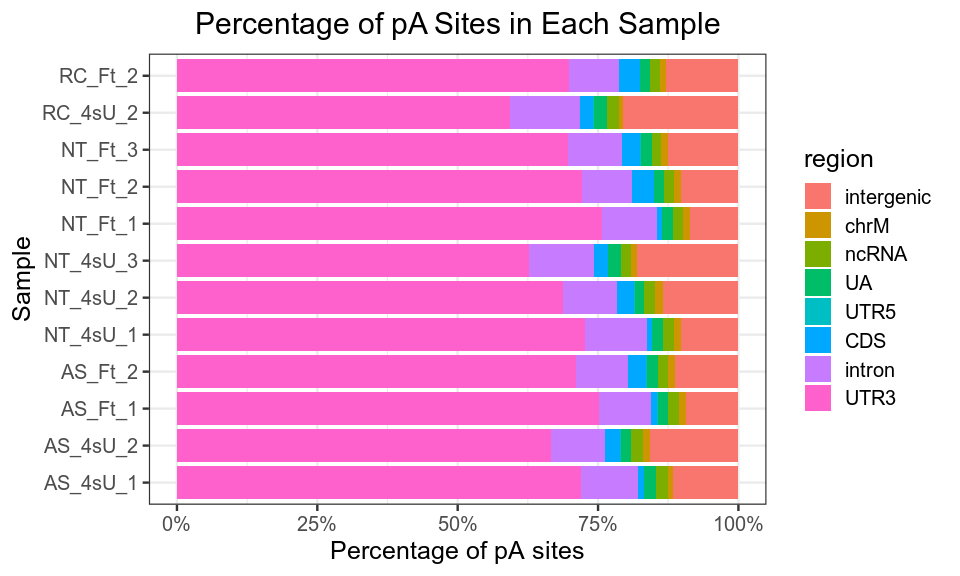

In [82]:
# Change plot size 
library(repr)
options(repr.plot.width=8, repr.plot.height=length(sample_names)*0.4)
p

Plot distribution of PASS reads. The ggplotly() function from the plotly library converts static ggplot2 figures into interactive figures.

In [83]:
read_summary = as.data.frame(read_summary)
read_summary$region = rownames(read_summary)
read_summary = gather(read_summary, key=Sample, value=num_read, -region)
read_summary$region = factor(read_summary$region, 
                             levels = c("intergenic", "chrM", "ncRNA", "UA",
                                        "UTR5", "CDS", "intron", "UTR3"))

p = ggplot(data=read_summary, aes(x=Sample, y=num_read, fill = region)) + 
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
#   scale_x_discrete(limits = rev(read_summary$Sample)) +
  ylab("Percentage of PASS reads") +
  coord_flip() +
  ggtitle("Percentage of PASS reads in Each Sample")

png(file.path(result_dir, "num_read_summary.png"), 800, length(sample_names)*50)
print(p)
dev.off()

# ggplotly(p) # Uncomment this if you want to see interactive plots.

png 
  2

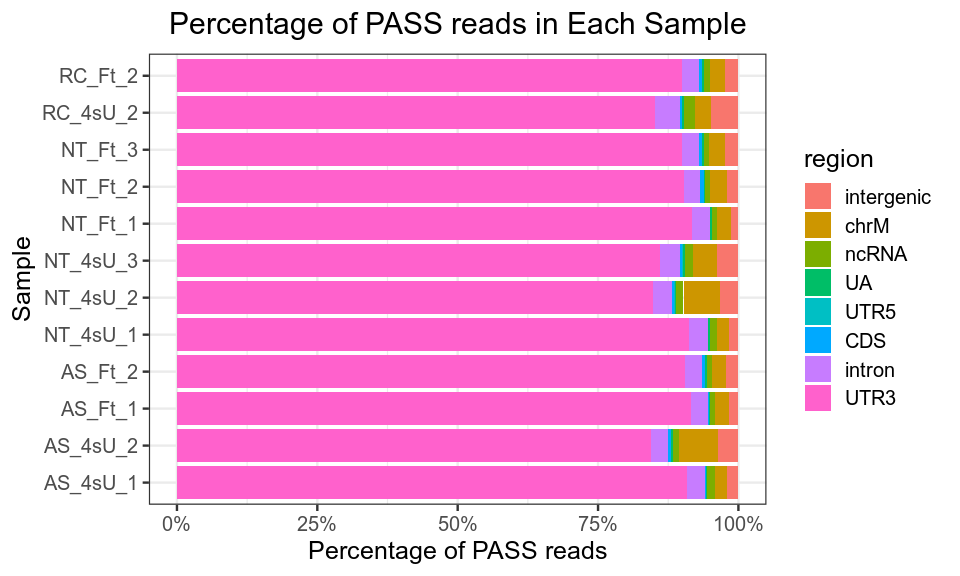

In [84]:
p

## 10. Plot nucleotide profile near pA sites

In [32]:
plot_nucleotide_profile = function(pA, 
                                   BSgeno = "BSgenome.Hsapiens.UCSC.hg19", 
                                   window_size = 100){
         #` A function for plotting nucleotide profile near pAs                                                
         require(GenomicRanges)                                                             
         require(BSgeno, character.only = T)                                                
         require(tidyr)                                                                     
         require(dplyr)                                                                     
         require(ggplot2)                                                                   
                                                                                            
         # Get genomic sequences                                                            
         seq = getSeq(eval(parse(text=BSgeno)), pA + window_size)                           
                                                                                            
         # Remove sequences with "N"                                                        
         seq = seq[!grepl("N", seq)]                                                        
                                                                                            
         # Computes the consensus matrix of a set of sequences                              
         m = consensusMatrix(seq)[1:4,]                                                     
                                                                                            
         # Normalization                                                                    
         m = scale(m, center = F, scale = colSums(m))                                       
                                                                                            
         # Column names indicates position relative to pA                                   
         colnames(m) = -window_size:window_size                                             
                                                                                            
         df = as.data.frame(t(m))                                                           
         df$Position = as.numeric(rownames(df))                                             
         
         p = df %>%                                                                         
           gather(key="Base", value = "Fraction", -Position) %>%                            
           ggplot(aes(x=Position, y=Fraction, color=Base)) +                                
           geom_line() +
           xlab("Position Relative to pA Site")
                                                                                    
         p                                                                                  
  }

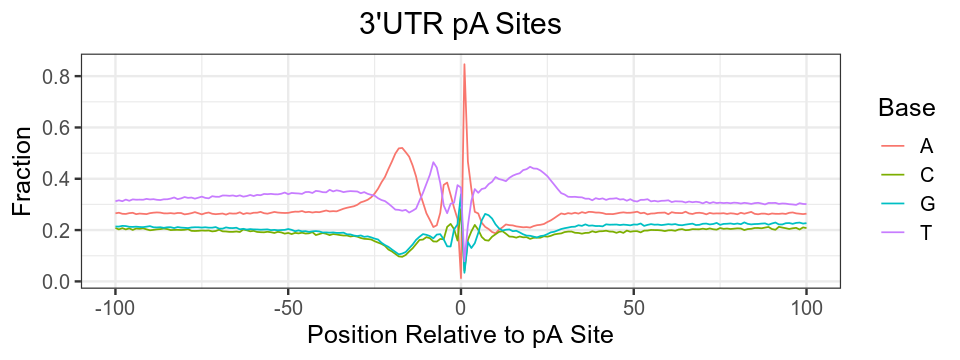

In [33]:
p_3UTR = plot_nucleotide_profile(pA[pA$region == "3UTR"], BSgeno) + ggtitle("3'UTR pA Sites")
p_3UTR 

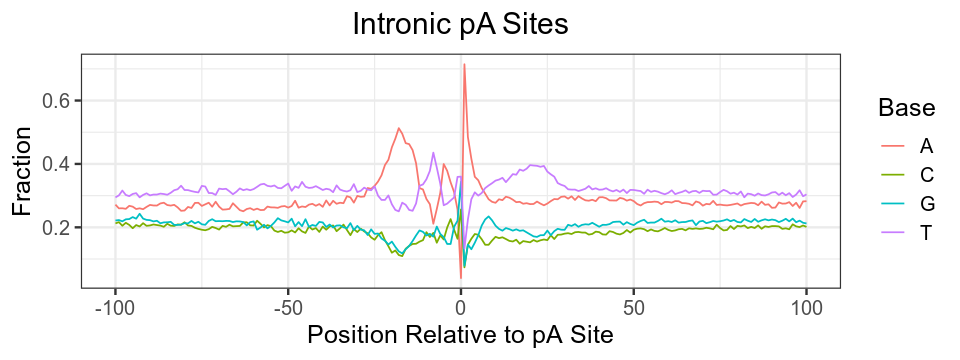

In [34]:
p_intron = plot_nucleotide_profile(pA[pA$region == "intron"], BSgeno) +
               ggtitle("Intronic pA Sites")
p_intron

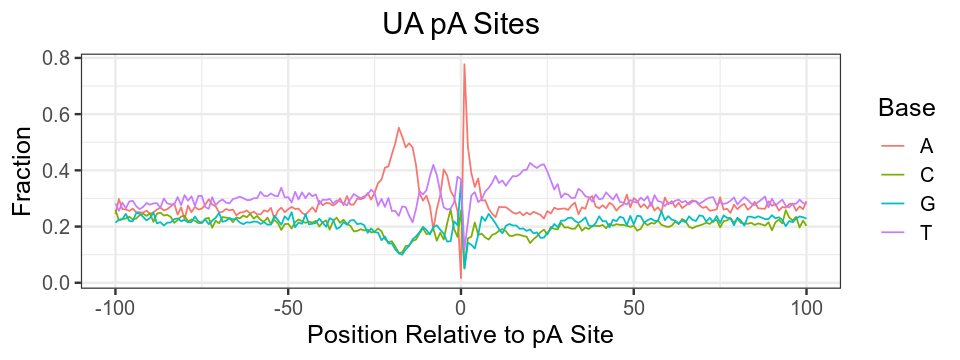

In [35]:
p_UA = plot_nucleotide_profile(pA[pA$region == "UA"], BSgeno) +
               ggtitle("UA pA Sites")
p_UA

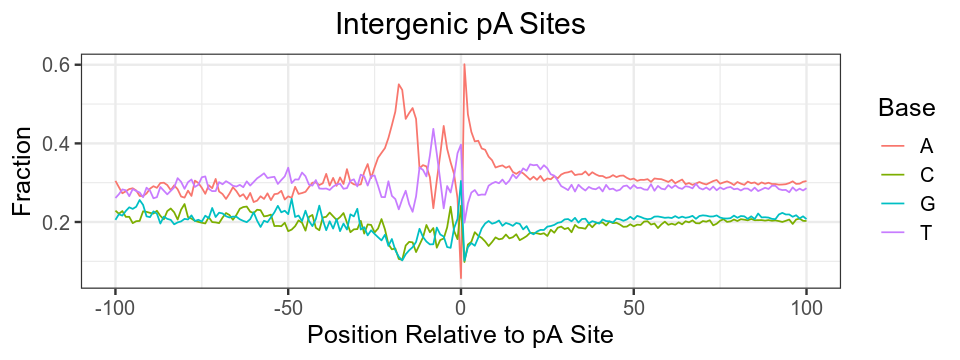

In [36]:
p_intergenic = plot_nucleotide_profile(pA[pA$region == "intergenic"], BSgeno) +
               ggtitle("Intergenic pA Sites")
p_intergenic

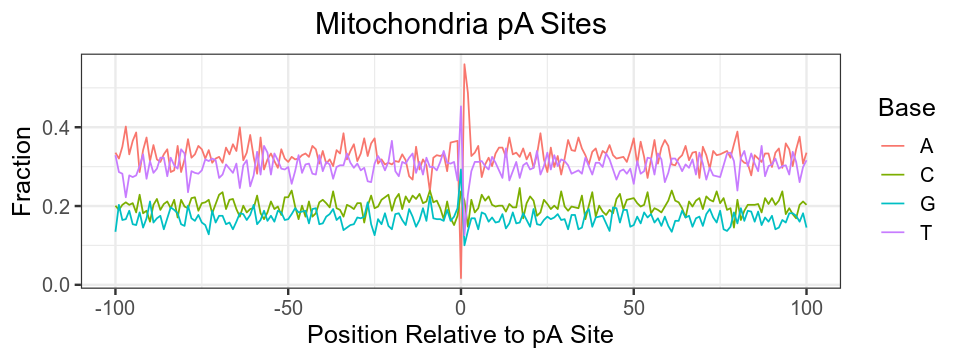

In [37]:
p_chrM = plot_nucleotide_profile(pA[pA$region == "chrM"], BSgeno) +
               ggtitle("Mitochondria pA Sites")
p_chrM

From the above plots, **we can see that 3'UTR, intronic, and UA pA sites have similar nucleotide profiles around the pA sites, while intergenice and mitochondria pA sites have nucleotide profiles different from regular pA sites.**

# 11. Calculate optimal transcript starting sites (TSSs) 
For genes with >1 UA pA sites and >1 TSSs, use the TSS closest to the most downstream UA pA site, otherwise only keep the most upstream TSS.

In [38]:
# Get TSS 
tss = promoters(txdb, upstream=0, downstream=1, columns=c("tx_name", "gene_id"))

# Convert the accession numbers of the genes into gene symbols
tss$gene_symbol = mapIds(org.db, keys = as.character(tss$tx_name),
                         keytype =  "ACCNUM", column =  "SYMBOL")

# Only consider detected genes
tss = tss[tss$gene_symbol %in% pA$gene_symbol]

# Remove duplicates (One gene can have multiple transcripts with the same TSS)
tss = data.frame(chr = seqnames(tss), strand = strand(tss), 
                 position = start(tss), gene_symbol = tss$gene_symbol)
tss = unique(tss)
tss$gene_symbol = as.vector(tss$gene_symbol)

# Calculate signed position for later use 
pA$signed_position = start(pA) * ifelse(strand(pA) == "+", 1, -1)
tss$signed_position = tss$position * ifelse(tss$strand == "+", 1, -1) 

# Split tss into two categories and treat them differently
tss_with_ua = tss[tss$gene_symbol %in% pA[pA$region == "UA"]$gene_symbol, ]
tss_without_ua = tss[!tss$gene_symbol %in% pA[pA$region == "UA"]$gene_symbol, ]

# Loop through genes in tss_with_ua, select the most reasonable TSS for each gene
tss_with_ua_new = data.frame()
for(gene in unique(tss_with_ua$gene_symbol)){
  tss_for_gene = subset(tss_with_ua, gene_symbol == gene)
  if(nrow(tss_for_gene) == 1){
    tss_with_ua_new = rbind(tss_with_ua_new, tss_for_gene)
  }else{
    # Determine the most reasonable UA pA sites: 
    # pick the UA pA sites upstream to all other UA pA sites
    ua_pA = pA[pA$gene_symbol == gene & pA$region == "UA"] # may have >1 rows
    # ua_pA$signed_position is negative if the gene is on positive strand!
    ua_pA = ua_pA[order(ua_pA$signed_position), ][1,] 
    # tss must be down stream of UA pA site 
    tss_for_gene = tss_for_gene[-ua_pA$signed_position - tss_for_gene$signed_position < 0,]
    # Select the tss closest to the UA pA site
    tss_for_gene = tss_for_gene[which.max(-ua_pA$signed_position - 
                                          tss_for_gene$signed_position),]
    tss_with_ua_new = rbind(tss_with_ua_new, tss_for_gene)
  }
}

# For tss without detected ua pA sites, simply pick the most upstream one
tss_without_ua = tss_without_ua[order(tss_without_ua$gene_symbol, 
                                      tss_without_ua$signed_position), ]
tss_without_ua = split(tss_without_ua, f=tss_without_ua$gene_symbol)
tss_without_ua = do.call(rbind, lapply(tss_without_ua, function(x) x[1,]))
                                       
# Combine the two data frame
tss = rbind(tss_with_ua_new, tss_without_ua)
df = data.frame(gene_symbol = as.vector(pA$gene_symbol))
                                       
# Unmatched rows will be put at the end of the merged table
df = merge(df, tss, by = "gene_symbol", all.x=T, sort=F)
                                       
# Cannot assume that the order remain the same even after setting sort = F
pA = pA[order(pA$gene_symbol)] 
df = df[order(df$gene_symbol),]
pA$tss_position = df$position

rm(tss)
rm(df)

'select()' returned 1:1 mapping between keys and columns


## 12.1. Calculate CDS features for the transcript with the longest CDS of each gene
Due to alternative splicing, some genes can have multiple transcripts with different CDS. This step will find the transcript with longest CDS. If there are ties, the transcript will be selected randomly.

In [39]:
# Calculate CDS features of the transcript with maximum CDS length for each gene
cds = cdsBy(txdb, by="tx", use.names=T) 

# Calculate total CDS length for each transcript
cds_length = foreach(i=1:length(cds), .combine = "c") %dopar%{
  sum(width(cds[i]))
}

# Split by gene symbols
cds_length = split(cds_length, mapIds(org.db, keys = names(cds_length), 
                                      keytype =  "ACCNUM", column =  "SYMBOL"))

# Get transcripts with longest CDS
max_cds_tx_name = names(sapply(cds_length, which.max))
max_cds_tx_name = sub("^.+\\.", "", max_cds_tx_name) 

# Get CDS sequence
maxCDS_seq = getSeq(eval(parse(text = BSspec)), cds[max_cds_tx_name])
maxCDS_seq = lapply(maxCDS_seq, function(x) unlist(x))
maxCDS_seq = DNAStringSet(maxCDS_seq)
                    
# Calculate base frequency
base_fraction = alphabetFrequency(maxCDS_seq, baseOnly=T, as.prob=T)
                    
CDS_features = data.frame(maxCDS_tx= names(maxCDS_seq), 
                          cds_start = unlist(start(range(cds[max_cds_tx_name]))),
                          cds_end = unlist(end(range(cds[max_cds_tx_name]))),
                          CDS_size = width(maxCDS_seq), 
                          CDS_GC = base_fraction[, "C"] + base_fraction[, "G"],
                          stringsAsFactors = F)
                    
CDS_features$gene_symbol =  mapIds(org.db, keys = CDS_features$maxCDS_tx, 
                                   keytype =  "ACCNUM", column =  "SYMBOL")

Warning message in .set_group_names(grl, use.names, txdb, by):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


## 12.2. Calculate intron features for the transcript with longest CDS of each gene

In [40]:
# Calculate features of introns of the longest CDS transcript
introns = intronsByTranscript(txdb, use.names=T)

introns = introns[names(introns) %in% CDS_features$maxCDS_tx]

intron_sizes = lapply(introns, function(intron) width(intron))
                      
# Remove NULL or 0-length introns                      
mask = sapply(intron_sizes, function(intron) length(intron) > 0)
introns = introns[mask]
intron_sizes = intron_sizes[mask]

intron_features = data.frame(maxCDS_tx = as.character(names(introns)), 
                             max_intron_size = sapply(intron_sizes, max), 
                             min_intron_size = sapply(intron_sizes, min),
                             total_intron_size = sapply(intron_sizes, sum),
                             num_intron = sapply(intron_sizes, function(sizes) sum(sizes > 0)),
                             stringsAsFactors = F)
                                                 
intron_features[intron_features %in% c(Inf, -Inf)] = 0

Warning message in .set_group_names(ans, use.names, x, "tx"):
“some group names are NAs or duplicated”

## 12.3. Calculate 5'UTR features for the transcript with longest CDS of each gene

In [41]:
# Calculation features of 5'UTRs of the longest CDS transcript
UTR5 = fiveUTRsByTranscript(txdb, use.names=T) 
UTR5 = UTR5[names(UTR5) %in% CDS_features$maxCDS_tx]

UTR5_seq = getSeq(eval(parse(text = BSspec)), UTR5)
UTR5_seq = lapply(UTR5_seq, function(x) unlist(x))
UTR5_seq = DNAStringSet(UTR5_seq)
                  
base_fraction = alphabetFrequency(UTR5_seq, baseOnly=T, as.prob=T)

UTR5_features = data.frame(maxCDS_tx = names(UTR5), 
                           UTR5_size = sapply(UTR5, function(UTR5) sum(width(UTR5))), 
                           UTR5_GC = base_fraction[, "C"] + base_fraction[, "G"],
                           stringsAsFactors = F)
                           

Warning message in .set_group_names(ans, use.names, txdb, "tx"):
“some group names are NAs or duplicated”

Predict uORFs in 5'UTRs:

In [42]:
# Predict uORF in 5'UTRs
orf_count = data.frame(gene_symbol = names(UTR5_seq), uORF = 0)

for(gene in names(UTR5_seq)){
  orf = findORFsinSeq(unlist(UTR5_seq[[gene]]))
  if(sum(orf[["lengths"]] > 30, na.rm = T)){
    orf_count[orf_count$gene_symbol == gene, "uORF"] = sum(orf[["lengths"]] > 30)
  }
}

uORF = orf_count$uORF
names(uORF) = orf_count$gene_symbol

pA$uORF = uORF[pA$gene_symbol]

## 12.4. Calculate non-coding RNA (ncRNA) features
*ncTx* was created in Step 5 when mapping pAs to non-coding RNAs.

In [43]:
# Get exonic sequence
ncRNA_seq = getSeq(eval(parse(text=BSgeno)), ncTx)

ncRNA_seq = lapply(ncRNA_seq, function(x) unlist(x))
                   
ncRNA_seq = DNAStringSet(ncRNA_seq)
                   
# Calculate GC content
base_fraction = alphabetFrequency(ncRNA_seq, baseOnly=T, as.prob=T)
ncRNA_features = data.frame(gene_symbol = names(ncRNA_seq), 
                            ncRNA_size = width(ncRNA_seq), 
                            ncRNA_GC = base_fraction[, "C"] + base_fraction[, "G"],
                            stringsAsFactors = F)

## 12.5. Combine 5'UTR, CDS, intron, and ncRNA features with pA sites in a dataframe
The *pas* dataframe will be mentioned a lot in downstream analysis. **pas** means **p**oly**a**denylation **s**ites. 

In [44]:
# Conver the GRanges into a dataframe for further calculation
pas = cbind(data.frame(chr = seqnames(pA), strand = strand(pA), pA_pos = start(pA)), 
              data.frame(mcols(pA)))
pas$pAid = with(pas, paste0(chr, strand, pA_pos))

utr3 = pas %>%
  dplyr::filter(region == "3UTR") %>%
  left_join(CDS_features, by = "gene_symbol") %>%
  left_join(UTR5_features, by = "maxCDS_tx") %>%
  left_join(intron_features, by = "maxCDS_tx") 

other = pas %>%
  dplyr::filter(region != "3UTR") %>%
  left_join(ncRNA_features, by = "gene_symbol")
  
pas = bind_rows(utr3, other)

pas[pas$region == "ncRNA", ]$tx_size = pas[pas$region == "ncRNA", ]$ncRNA_size 

rm(CDS_features, intron_features, UTR5_features, ncRNA_features)

Warning message in `[<-.data.frame`(`*tmp*`, pas$region == "ncRNA", , value = structure(list(:
“provided 35 variables to replace 34 variables”

## 12.6. Calculate exonic 3'UTR sequence, GC content, size, transcript size, and gene_size
Some 3'UTRs contain introns. To get exonic 3'UTR sequences, I first get genomic sequences between CDS ends and the pA sites for all the pA sites, then update sequences for 3'UTRs containing introns that do not overlap with any annotated 3'UTRs.

In [45]:
geno = eval(parse(text = BSspec))

# Create 3'UTR GRanges for pAs mapped to 3'UTRs, introns included      
pA_3UTR = create_3UTRs_from_pAs(pas) 

# Get genomic sequence for the 3'UTRs, without removing intronic sequences
pA_3UTR$exonic_3UTR_seq = as.character(getSeq(geno, pA_3UTR))

# Remove introns mapped to >1 strands
introns = intronsByTranscript(txdb, use.names=T)
introns = rename_grl(introns, old_key = "ACCNUM", new_key = "SYMBOL")
introns = unlist(introns)

# Remove 3pUTRs mapped to >1 strands
threeUTRs = threeUTRsByTranscript(txdb, use.names=T)
threeUTRs = rename_grl(threeUTRs, old_key = "ACCNUM", new_key = "SYMBOL")
threeUTRs = unlist(threeUTRs)

rm(txdb)

# Only keep intronic regions not overlapping with any annotated 3'UTRs
introns = setdiff(introns, threeUTRs)

# Make a list to work on individual 3'UTR containing introns
pA_3UTR_lst = split(pA_3UTR, pA_3UTR$pAid)
olp = findOverlaps(introns, pA_3UTR_lst, type = "within")

# Remove intron from each 3'UTR, then get genomic sequence
pA_3UTR[subjectHits(olp), ]$exonic_3UTR_seq = sapply(1:length(olp), function(i) {
  gr = setdiff(pA_3UTR_lst[[subjectHits(olp[i])]], introns[queryHits(olp[i])])   
  as.character(unlist(getSeq(geno, gr)))
  }
)

# Calculate 3'UTR GC content
utr3_seq = DNAStringSet(pA_3UTR$exonic_3UTR_seq)
base_fraction = alphabetFrequency(utr3_seq, baseOnly=T, as.prob=T)
pA_3UTR$UTR3_GC = base_fraction[, "C"] + base_fraction[, "G"]
pA_3UTR$UTR3_size = width(utr3_seq)

# Add the 3'UTR features to pas data frame
pas = merge(pas, 
            as.data.frame(mcols(pA_3UTR)[, c("pAid", "exonic_3UTR_seq", 
                                             "UTR3_GC", "UTR3_size")]), 
            all.x=T, sort=F)

# Calculate transcript size
pas$tx_size = rowSums(pas[, c("UTR5_size", "CDS_size", "UTR3_size")])

# Gene_size is the distance between pA site and TSS
pas$gene_size = abs(pas$pA_pos - pas$tss_position)
pas$gene_size = ifelse(pas$region == "UA", -1*pas$gene_size, pas$gene_size)

Warning message in .set_group_names(ans, use.names, x, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns
Warning message in .set_group_names(ans, use.names, txdb, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


Let's check if CDS and 3'UTR GC content are correlated:

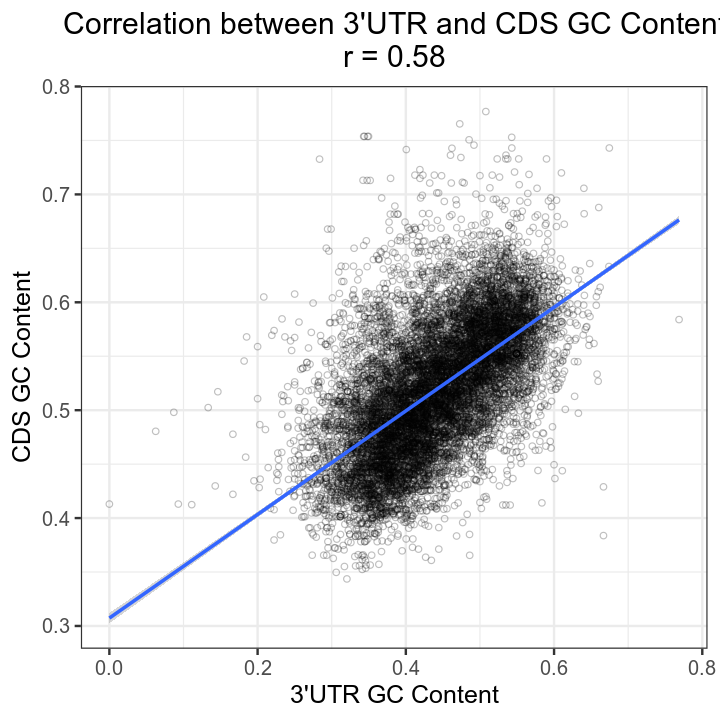

In [63]:
# Calculate Pearson correlation coefficient
r = round(cor(pas$UTR3_GC, pas$CDS_GC, use= "complete.obs"), 2)
t = "Correlation between 3'UTR and CDS GC Content"
t = paste0(t, "\n", "r = ", r)

options(repr.plot.width=6, repr.plot.height=6)
p = pas %>% 
  dplyr::filter(!is.na(UTR3_GC), !is.na(CDS_GC)) %>%
  ggplot(aes(x=UTR3_GC, y=CDS_GC)) + 
  geom_point(shape=1, alpha=0.25) +
  geom_smooth(method="rlm") +
  xlab("3'UTR GC Content") +
  ylab("CDS GC Content") +
  ggtitle(t)

p

# Interactive plot:
# ggplotly(p)

## 13. Identify subtypes of pA sites.
3'UTR pA sites are further classified into "S" (Single), "F" (First), "M" (Middle), and "L" (Last) subtypes.

In [47]:
# Calculate pA_type
pas$pA_type = ifelse(grepl("intron", pas$region), "I", 
                       ifelse(grepl("CDS|5UTR", pas$region), "E", 
                              ifelse(pas$region == "UA", "UA",
                                     ifelse(pas$region == "chrM", "chrM",
                                            ifelse(pas$region == "intergenic", "Intergenic",
                                                   "SFML"))))) # ncRNA may also have SFML types

pas$pA_type[table(pas$gene_symbol)[pas$gene_symbol] == 1 & pas$pA_type == "SFML"] = "S"

pas$signed_pA_pos = pas$pA_pos * ifelse(pas$strand == "+", 1, -1)

tmp = dplyr::filter(as.data.frame(pas), pA_type == "SFML") %>%
  group_by(gene_symbol) %>%
  mutate(percrank=percent_rank(signed_pA_pos))

tmp$pA_type = ifelse(tmp$percrank == 0, "F", 
                     ifelse(tmp$percrank == 1, "L", "M"))

pas = rbind(pas[pas$pA_type != "SFML",], as.data.frame(tmp[, -grep("percrank", names(tmp))]))

pas = as.data.frame(pas) %>% 
      group_by(gene_symbol) %>%
      arrange(signed_pA_pos)

pas = as.data.frame(pas)

rm(tmp)

## 14. Calculate poly(A) signal (PAS) using the 40 nt sequence upstream of pA sites

In [48]:
# Calculate PAS using the 40 nt sequence upstream of pA
motifcounts = countAllMotif(pas, geno = GENOME, search_from = 0, 
                            search_len = 40, motif_width = 6)

PASs = c("AATAAA","ATTAAA", "AGTAAA", "TATAAA", "CATAAA", "GATAAA", "AATATA", "AATACA", 
         "AATAGA", "AAAAAG", "ACTAAA", "AAAAAA")

motifcounts = motifcounts[, PASs]

PAScounts = cbind(motifcounts[, PASs[1:2]], 
                  OtherPAS = rowSums(motifcounts[, PASs[3:(length(PASs) -1)]]),
                  Arich = motifcounts[, "AAAAAA"])

PAScounts = as.data.frame(PAScounts)

pas$PAS = ifelse(PAScounts$AATAAA > 0, "AATAAA", 
                   ifelse(PAScounts$ATTAAA > 0, "ATTAAA",
                          ifelse(PAScounts$OtherPAS > 0, "OtherPAS",
                                 ifelse(PAScounts$Arich > 0, "Arich", "NoPAS"))))
rm(motifcounts)
rm(PAScounts)

Do different types of pA sites tend to use different PAS (poly(A) signal)?

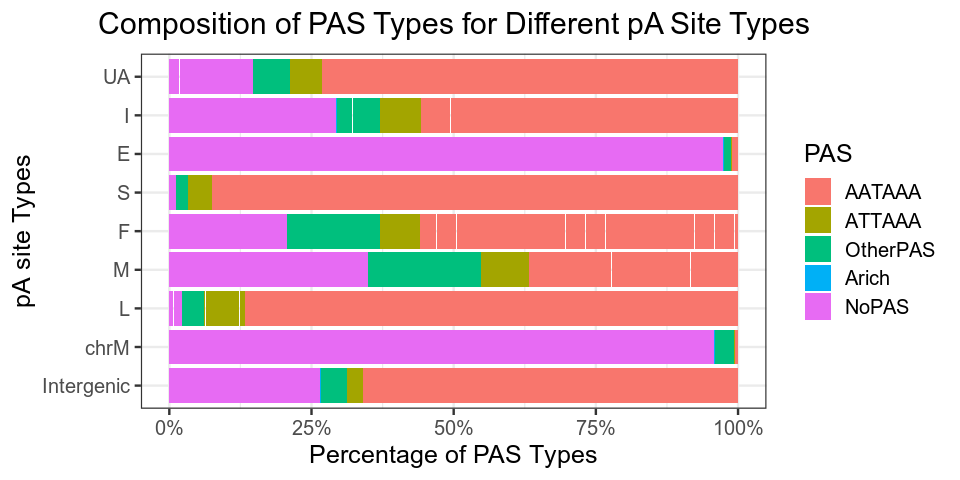

In [49]:
options(repr.plot.width=8, repr.plot.height=4)

pas %>% 
  dplyr::select(pA_type, PAS) %>%
  drop_na() %>% 
  group_by(pA_type, PAS) %>%
  mutate(count = n()) %>%
  ungroup() %>%
  mutate(pA_type = factor(pA_type, levels = rev(c("UA", "I", 'E', "S", "F", "M", "L",  
                                              "ncRNA", "chrM", "Intergenic")))) %>%
  mutate(PAS = factor(PAS, levels = c("AATAAA", "ATTAAA", "OtherPAS", "Arich", "NoPAS"))) %>%
  ggplot(aes(x = pA_type, y = count, fill = PAS)) +
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
  ylab("Percentage of PAS Types") +
  xlab("pA site Types") +
  ggtitle("Composition of PAS Types for Different pA Site Types") +
  coord_flip() 

From the above plot, it seems that pA sites mapped to mitochondria (chrM) and CDS or 5'UTRs (E) tend to have no obvious PAS. On the other hand, UA and intergenic pA sites also have PAS similar to 3'UTR pA sites (especially S (single pA site per gene) and L (last 3'UTR pA sites in APA 3'UTRs)). Compared with L pA sites, F (first pA sites in APA 3'UTRs) and M (middle pA sites in APA 3'UTRs) sites tend to have more weaker PAS.

## 15.1. Calculate RPM (Reads Per Million)
To reduce the effect of extreme values when calculating RPM, only sum up read numbers between 0.5 and 0.95 quantile. UA reads and intergenic reads will not be included when calculating total reads numbers.

In [50]:
# Calculate RPM, using total reads 
for(sample_name in sample_names){
  # only use genic reads
  all_counts = pas[pas$gene_symbol != "Unknown", sample_name] 
  # between 0.5 and 0.95 quantile
  lower_upper = quantile(all_counts, c(0.05, 0.95))
  trimmed_counts = all_counts[all_counts >= lower_upper[1] & all_counts <= lower_upper[2]]
    
  pas[,paste0(sample_name, "_rpm")] = 10^6*pas[,sample_name]/sum(trimmed_counts)
}

## 15.2. Calculate total read number per gene, without including reads from UA pA sites

In [51]:
# Calculate total reads number per gene, without counting pAs in UA 
num_per_gene = aggregate(pas[pas$region != "UA" & pas$region != "intergenic", sample_names], 
                         list(gene_symbol = pas[pas$region != "UA" & 
                                                pas$region != "intergenic",]$gene_symbol
                             ), 
                         sum)

names(num_per_gene)[-1] = paste0(names(num_per_gene)[-1], "_gene")

pas = merge(pas, num_per_gene, all.x = T, sort = F)

rm(num_per_gene)

## 15.3. Calculate number of pAs per gene

In [52]:
# Calculate number of pAs per gene
Num_pA = as.data.frame(table(pas$gene_symbol[pas$gene_symbol != "Unknown"]))

names(Num_pA) = c("gene_symbol", "Num_pA")

pas = merge(pas, Num_pA, by = "gene_symbol", all.x=T, sort=F)

rm(Num_pA)

## 15.4. Calculate pA site usage (fraction of PASS reads from each pA site) for each gene

In [53]:
# Calculate pA usage
for(sample_name in sample_names){
  pas[, paste0(sample_name, "_usage")] = 0
    
  pas[pas$region != "UA", paste0(sample_name, "_usage")] = 
    100*pas[pas$region != "UA", sample_name]/
        pas[pas$region != "UA", paste0(sample_name, "_gene")]
}

## 15.5. Calculate total 3'UTR reads per gene

In [54]:
#### Calculate total 3'UTR reads per gene
num_in_3utr_per_gene = aggregate(pas[pas$region == "3UTR", sample_names], 
                                 list(gene_symbol= pas[pas$region == "3UTR",]$gene_symbol),
                                 sum)

names(num_in_3utr_per_gene)[-1] = paste0(names(num_in_3utr_per_gene)[-1], "_3utr")

pas = merge(pas, num_in_3utr_per_gene, all.x=T, sort = F)

rm(num_in_3utr_per_gene)

## 15.6. Calculate total 3'UTR rpms per gene

In [55]:
# Calculate total 3'UTR rpms per gene
rpm_in_3utr_per_gene = aggregate(pas[pas$region == "3UTR", paste0(sample_names, "_rpm")], 
                                 list(gene_symbol= pas[pas$region == "3UTR",]$gene_symbol),
                                 sum)

names(rpm_in_3utr_per_gene)[-1] = paste0(names(rpm_in_3utr_per_gene)[-1], "_3utr")

pas = merge(pas, rpm_in_3utr_per_gene, all.x=T, sort = F)

rm(rpm_in_3utr_per_gene)

# Change column names
colnames(pas) = sub("(_\\d+[a-z]?)$", "\\1_count", colnames(pas))

In [56]:
# Calculate genewise RPM
for(samplename in sample_names){
  all_counts = pas[, paste0(samplename, "_count")]
  lower_upper = quantile(all_counts, c(0.05, 0.95))
  trimmed_counts = all_counts[all_counts >= lower_upper[1] & all_counts <= lower_upper[2]]
  pas[, paste0("Gene_RPM_", samplename)] = 10^6 * pas[, paste0(samplename, "_gene")]/
                                                  sum(trimmed_counts)
}

## 16. Filter out lowly expressed pAs and check corrrelation between samples

In [57]:
# Filter lowly expressed pAs
if(exists("filter_strength")){
  if(filter_strength < 0 | filter_strength > 1){
    stop("filter_strength must be between 0 and 1.")
  }
}else{
  # between 0 and 1, bigger filter_strength means more stringent filtering
  filter_strength = 1/2 
}

filter1 = rowSums(pas[,grepl("_usage$", names(pas))] >= 
          lowest_usage, na.rm = T) >= length(sample_names)*filter_strength
filter2 = rowSums(pas[,grepl("_rpm$", names(pas))] >= lowest_rpm, na.rm = T) >= 
          length(sample_names)*filter_strength
filter3 = rowSums(pas[,grepl("_count$", names(pas))] >= lowest_count, na.rm = T) >= 
          length(sample_names)*filter_strength

# Keep pAs in other genic regions (outside of 3'UTRs)
filter4 = pas$region != "3UTR"
pas = pas[(filter1 & filter2 & filter3)|filter4, ]

We can have a look at how the samples are correlated, which may help us identify outliers:

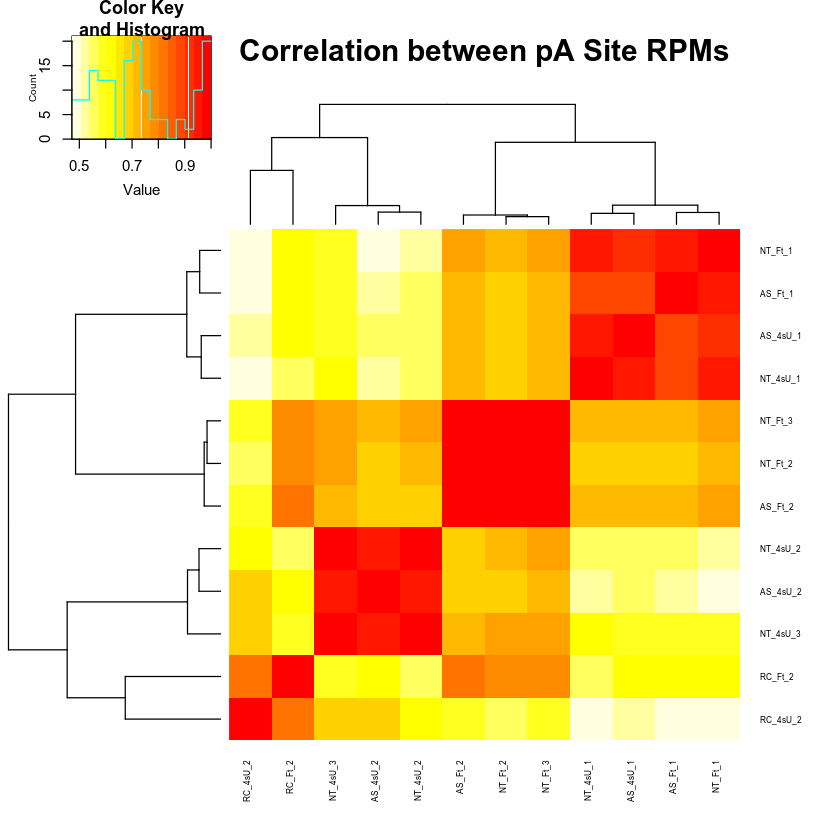

In [88]:
options(repr.plot.width=7, repr.plot.height=7)
df = pas[, grep("_rpm$", names(pas))]
names(df) = sub("_rpm", "", names(df))

# I prefer pheatmap, but it is not working now
heatmap.2(cor(df), col=rev(heat.colors(16)), main = "Correlation between pA Site RPMs", 
          trace="none", margins = c(5,5), cexRow = 0.5, cexCol = 0.5)

We can see that batch 1 samples (C_1 and N_1) are highligh correlated with each other but weakly correlated with batch 2 and batch 3 samples. Maybe it is a good idea to remove batch 1 samples from further analysis.

## 17. Add gene_symbol and gene_id

In [59]:
# Add gene_symbol and gene_id using org.x.db
pas$gene_id = as.numeric(mapIds(org.db, keys = pas$gene_symbol, 
                                keytype =  "SYMBOL", column =  "ENTREZID"))

pas$description = mapIds(org.db, keys = pas$gene_symbol, 
                         keytype = "SYMBOL", column = "GENENAME")

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


**This is the end of Part-2 of the pipeline. The *pas* data frame can be saved for further analysis.**

In [90]:
write.csv(pas, file.path(result_dir, "pas.csv"), row.names=F)